In [1]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io 
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor as GBR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline
warnings.filterwarnings('ignore')
#from google.colab.patches import cv2_imshow

## Exploring the AFLW2000 Dataset

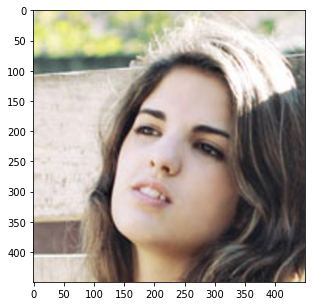

In [2]:
# Displaying a random image
plt.figure(figsize=(5,5))

img = cv2.imread('AFLW2000/image00072.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [3]:
# Exploring the associated landmark data
mat = scipy.io.loadmat('AFLW2000/image00072.mat')
print(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Mar 29 22:50:28 2016', '__version__': '1.0', '__globals__': [], 'pt2d': array([[ -1.        , 190.01802901, 214.79529479, 268.91907514,
        301.31897925, 324.12973993, 173.89313168, 193.16437367,
        211.25569673, 271.03568969, 290.70018508, 315.87070425,
         -1.        , 188.28323699, 209.09248555, 237.70520231,
         -1.        , 167.60052173, 193.95095984, 230.52685935,
        161.30791178],
       [452.        , 169.3304715 , 179.16267951, 196.0867052 ,
        200.79360062, 210.23255524, 201.97344018, 202.36677295,
        207.47954334, 225.9641198 , 230.68363679, 244.44877563,
        452.        , 255.9132948 , 248.10982659, 271.52023121,
        452.        , 297.14949309, 302.26226348, 319.56700037,
        374.62755571]]), 'Illum_Para': array([[ 1.17145705,  1.15171635,  1.05780399,  0.08651099,  0.23398474,
         0.49288037,  0.64861751, -1.04868042,  0.        , 20.        ]]), 'Col

In [4]:
# Exploring the associated pose yaw and pitch data
pose_para = mat["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]

[landmark {
  x: 0.43615564703941345
  y: 0.6298581957817078
  z: -0.08758661895990372
}
landmark {
  x: 0.45678025484085083
  y: 0.5520442128181458
  z: -0.11110793054103851
}
landmark {
  x: 0.45821434259414673
  y: 0.5866752862930298
  z: -0.06899455934762955
}
landmark {
  x: 0.47402435541152954
  y: 0.49711936712265015
  z: -0.058706313371658325
}
landmark {
  x: 0.46407949924468994
  y: 0.5313442945480347
  z: -0.11288399994373322
}
landmark {
  x: 0.4777962267398834
  y: 0.5117734670639038
  z: -0.09748638421297073
}
landmark {
  x: 0.5140475034713745
  y: 0.47081273794174194
  z: -0.0225435309112072
}
landmark {
  x: 0.3978862166404724
  y: 0.44637465476989746
  z: 0.10839911550283432
}
landmark {
  x: 0.5366540551185608
  y: 0.4285270571708679
  z: 0.005548629444092512
}
landmark {
  x: 0.545939028263092
  y: 0.4025465250015259
  z: 0.010496490634977818
}
landmark {
  x: 0.5878693461418152
  y: 0.3177938759326935
  z: 0.06591738015413284
}
landmark {
  x: 0.4321920871734619
  

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


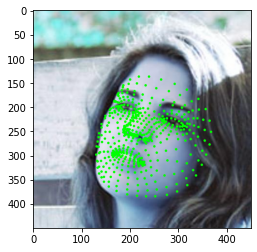

In [5]:
# Exploring mediapipe's detected landmarks for this image
faceModule = mediapipe.solutions.face_mesh
with faceModule.FaceMesh(static_image_mode=True) as faces:
    image = cv2.imread('AFLW2000/image00072.jpg')
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
        for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
            cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    print(results.multi_face_landmarks)

    plt.imshow(image)

### Landmark data obtained by mediapipe - Features

In [6]:
def landmark_gatherer(image_path):
    x_coords= []
    y_coords= []
    
    
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        
        image = cv2.imread(image_path)
        if(image is not None):
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
                for face in results.multi_face_landmarks:

                    for landmark in face.landmark:

                        x = landmark.x
                        y = landmark.y
                        shape = image.shape 
                        x_coords.append(x)
                        #x_coords.append(int(x * shape[1]))
                        #y_coords.append(int(y * shape[0]))

    return np.array(x_coords) #, np.array(y_coords)

In [7]:
def y_landmark_gatherer(image_path):
    x_coords= []
    y_coords= []
    
    
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        
        image = cv2.imread(image_path)
        if(image is not None):
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
                for face in results.multi_face_landmarks:

                    for landmark in face.landmark:

                        x = landmark.x
                        y = landmark.y
                        shape = image.shape 
                        y_coords.append(y)
                        #x_coords.append(int(x * shape[1]))
                        #y_coords.append(int(y * shape[0]))

    return np.array(y_coords) #, np.array(y_coords)

In [8]:
y_landmarks = []
y_landmarks = [y_landmark_gatherer(file) for file in glob.glob("AFLW2000/*.jpg")]

In [9]:
landmarks = []
landmarks = [landmark_gatherer(file) for file in glob.glob("AFLW2000/*.jpg")]

In [10]:
df=pd.DataFrame(landmarks)

In [11]:
display(df.head())

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,0.482634,0.454764,0.476356,0.453344,0.452160,0.456506,0.474137,0.405678,0.476299,0.473069,...,0.479624,0.487026,0.520809,0.474651,0.479252,0.532465,0.521886,0.512907,0.615663,0.626102
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.444453,0.410503,0.446220,0.423494,0.406379,0.414543,0.446625,0.450198,0.452114,0.447651,...,0.435093,0.437753,0.473347,0.430233,0.439566,0.505528,0.494927,0.484308,0.564700,0.573730
3,0.500663,0.506520,0.503007,0.488755,0.507540,0.507743,0.507411,0.340506,0.508163,0.509409,...,0.525229,0.537338,0.558449,0.521828,0.518655,0.559947,0.549014,0.543016,0.666964,0.679552
4,0.442689,0.438366,0.452242,0.450696,0.441129,0.452072,0.484823,0.401197,0.501079,0.505318,...,0.463202,0.473704,0.503379,0.457572,0.460417,0.550818,0.537517,0.527094,0.644199,0.659417


In [12]:
df2=pd.DataFrame(y_landmarks)
display(df2.info())
display(df2.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Columns: 468 entries, 0 to 467
dtypes: float64(468)
memory usage: 7.1 MB


None

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,0.657504,0.608295,0.622833,0.553884,0.591979,0.569897,0.513484,0.506315,0.470494,0.447985,...,0.613028,0.607281,0.611539,0.614601,0.617405,0.502995,0.507631,0.511504,0.486897,0.479048
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.667499,0.622930,0.636096,0.568230,0.607547,0.586271,0.528131,0.502607,0.484803,0.464929,...,0.627931,0.624065,0.631813,0.629081,0.631930,0.511325,0.517963,0.523888,0.502823,0.495090
3,0.662845,0.614361,0.629867,0.543706,0.593160,0.564785,0.495251,0.481029,0.436173,0.405202,...,0.619671,0.613125,0.618101,0.622068,0.624857,0.493782,0.496619,0.498876,0.480764,0.471546
4,0.649885,0.585021,0.609392,0.525981,0.565670,0.543515,0.491138,0.467243,0.442095,0.415695,...,0.599060,0.595454,0.615544,0.598992,0.604326,0.501989,0.503194,0.503840,0.515006,0.507407


In [13]:
frames = [df, df2]
  
fin_df = pd.concat([df, df2], axis=1, join='inner')
display(fin_df)
fin_df.info()

,0,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,0.482634,0.454764,0.476356,0.453344,0.452160,0.456506,0.474137,0.405678,0.476299,0.473069,...,0.613028,0.607281,0.611539,0.614601,0.617405,0.502995,0.507631,0.511504,0.486897,0.479048
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.444453,0.410503,0.446220,0.423494,0.406379,0.414543,0.446625,0.450198,0.452114,0.447651,...,0.627931,0.624065,0.631813,0.629081,0.631930,0.511325,0.517963,0.523888,0.502823,0.495090
3,0.500663,0.506520,0.503007,0.488755,0.507540,0.507743,0.507411,0.340506,0.508163,0.509409,...,0.619671,0.613125,0.618101,0.622068,0.624857,0.493782,0.496619,0.498876,0.480764,0.471546
4,0.442689,0.438366,0.452242,0.450696,0.441129,0.452072,0.484823,0.401197,0.501079,0.505318,...,0.599060,0.595454,0.615544,0.598992,0.604326,0.501989,0.503194,0.503840,0.515006,0.507407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,0.460239,0.437474,0.461935,0.443815,0.435480,0.443040,0.469531,0.420773,0.476189,0.473806,...,0.616613,0.610561,0.622814,0.617906,0.622469,0.512587,0.517867,0.521576,0.502012,0.491539
1995,0.499144,0.510562,0.504578,0.497040,0.512925,0.514527,0.516750,0.366006,0.520499,0.523518,...,0.643644,0.637316,0.645429,0.646164,0.648803,0.495540,0.502051,0.507436,0.488374,0.480504
1996,0.512581,0.539129,0.522964,0.526245,0.542681,0.542203,0.536168,0.403888,0.537990,0.541842,...,0.617515,0.613191,0.617830,0.619457,0.621288,0.515440,0.518615,0.521467,0.509767,0.507116
1997,0.505022,0.483085,0.498209,0.474573,0.480736,0.482658,0.493536,0.407637,0.496554,0.495365,...,0.639855,0.634229,0.629911,0.642638,0.642996,0.507472,0.514130,0.520402,0.502133,0.494620


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Columns: 936 entries, 0 to 467
dtypes: float64(936)
memory usage: 14.3 MB


### Labels obtained from the mat files 

In [14]:
def pitch_finder(path):
    mat = scipy.io.loadmat(path)

    pose_para = mat["Pose_Para"][0][:3]
    pitch = pose_para[0]
    yaw = pose_para[1]
    roll = pose_para[2]
    return pitch

In [15]:
pitch_labels = []
pitch_labels = [pitch_finder(file) for file in glob.glob("AFLW2000/*.mat")]
pitch_labels = np.array(pitch_labels)

In [16]:
def yaw_finder(path):
    mat = scipy.io.loadmat(path)

    pose_para = mat["Pose_Para"][0][:3]
    pitch = pose_para[0]
    yaw = pose_para[1]
    roll = pose_para[2]
    return yaw

In [17]:
yaw_labels = []
yaw_labels = [yaw_finder(file) for file in glob.glob("AFLW2000/*.mat")]
yaw_labels = np.array(yaw_labels)

In [18]:
def roll_finder(path):
    mat = scipy.io.loadmat(path)

    pose_para = mat["Pose_Para"][0][:3]
    pitch = pose_para[0]
    yaw = pose_para[1]
    roll = pose_para[2]
    return roll

In [19]:
roll_labels = []
roll_labels = [roll_finder(file) for file in glob.glob("AFLW2000/*.mat")]
roll_labels = np.array(roll_labels)

## Adding Labels to Features

1. The Pitch Dataset (to predict pitch)

In [20]:
pitch_temp = pd.DataFrame(pitch_labels, columns=['Pitch'])
pitch_temp.head()

,Pitch
0,-0.315775
1,-0.320829
2,-0.098325
3,0.324776
4,-0.093529


In [21]:
#pitch_dataset = fin_df
pitch_dataset= pd.concat([fin_df, pitch_temp], axis=1)

display(pitch_dataset.describe())

,0,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,Pitch
count,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,...,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1999.000000
mean,0.505036,0.503698,0.504510,0.490213,0.503416,0.503320,0.503473,0.391003,0.503083,0.502743,...,0.609631,0.617820,0.617693,0.620996,0.497822,0.503258,0.507431,0.485716,0.478221,-0.107110
std,0.041261,0.053271,0.037840,0.044587,0.054824,0.050828,0.040721,0.046108,0.045301,0.050667,...,0.026692,0.024105,0.027240,0.025764,0.024391,0.023010,0.022426,0.038984,0.041212,0.628274
min,0.256906,0.227159,0.249772,0.222207,0.223030,0.224847,0.235638,0.194867,0.234697,0.229952,...,0.140728,0.139288,0.147400,0.148695,0.049809,0.055864,0.060640,0.032022,0.024076,-12.457202
25%,0.482141,0.469521,0.481937,0.460069,0.466724,0.469033,0.477889,0.360396,0.477494,0.474297,...,0.597482,0.607415,0.605450,0.609787,0.484851,0.491350,0.496217,0.463229,0.454632,-0.258600
50%,0.505162,0.501536,0.503587,0.485371,0.501211,0.501135,0.501599,0.382895,0.501910,0.501683,...,0.612626,0.619903,0.620663,0.623425,0.496684,0.502106,0.506317,0.485355,0.477745,-0.121962
75%,0.526248,0.537543,0.525717,0.516599,0.538674,0.535442,0.529181,0.417413,0.527620,0.530301,...,0.625206,0.630403,0.634025,0.636259,0.509189,0.513950,0.517966,0.506548,0.499799,0.040306
max,0.928491,0.929157,0.923774,0.901552,0.926027,0.918533,0.896907,0.802042,0.883313,0.878124,...,0.774652,0.775468,0.778855,0.779742,0.719222,0.720868,0.723342,0.741343,0.750775,15.598820


In [22]:
pitch_dataset=pitch_dataset.dropna()

In [23]:
display(pitch_dataset.describe())

,0,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,Pitch
count,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,...,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000
mean,0.505036,0.503698,0.504510,0.490213,0.503416,0.503320,0.503473,0.391003,0.503083,0.502743,...,0.609631,0.617820,0.617693,0.620996,0.497822,0.503258,0.507431,0.485716,0.478221,-0.104846
std,0.041261,0.053271,0.037840,0.044587,0.054824,0.050828,0.040721,0.046108,0.045301,0.050667,...,0.026692,0.024105,0.027240,0.025764,0.024391,0.023010,0.022426,0.038984,0.041212,0.637013
min,0.256906,0.227159,0.249772,0.222207,0.223030,0.224847,0.235638,0.194867,0.234697,0.229952,...,0.140728,0.139288,0.147400,0.148695,0.049809,0.055864,0.060640,0.032022,0.024076,-12.457202
25%,0.482141,0.469521,0.481937,0.460069,0.466724,0.469033,0.477889,0.360396,0.477494,0.474297,...,0.597482,0.607415,0.605450,0.609787,0.484851,0.491350,0.496217,0.463229,0.454632,-0.256462
50%,0.505162,0.501536,0.503587,0.485371,0.501211,0.501135,0.501599,0.382895,0.501910,0.501683,...,0.612626,0.619903,0.620663,0.623425,0.496684,0.502106,0.506317,0.485355,0.477745,-0.121962
75%,0.526248,0.537543,0.525717,0.516599,0.538674,0.535442,0.529181,0.417413,0.527620,0.530301,...,0.625206,0.630403,0.634025,0.636259,0.509189,0.513950,0.517966,0.506548,0.499799,0.040078
max,0.928491,0.929157,0.923774,0.901552,0.926027,0.918533,0.896907,0.802042,0.883313,0.878124,...,0.774652,0.775468,0.778855,0.779742,0.719222,0.720868,0.723342,0.741343,0.750775,15.598820


In [24]:
X_p = pitch_dataset.loc[:, pitch_dataset.columns != "Pitch"]
y_p = pitch_dataset.Pitch

In [25]:
X_p_train, X_p_test, y_p_train, y_p_test = train_test_split(X_p, y_p, test_size=0.2, random_state=42)

2. The Roll Dataset

In [26]:
roll_temp = pd.DataFrame(roll_labels, columns=['Roll'])
roll_dataset= pd.concat([fin_df, roll_temp], axis=1)
roll_dataset=roll_dataset.dropna()
display(roll_dataset.describe())

,0,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,Roll
count,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,...,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000
mean,0.505036,0.503698,0.504510,0.490213,0.503416,0.503320,0.503473,0.391003,0.503083,0.502743,...,0.609631,0.617820,0.617693,0.620996,0.497822,0.503258,0.507431,0.485716,0.478221,-0.038838
std,0.041261,0.053271,0.037840,0.044587,0.054824,0.050828,0.040721,0.046108,0.045301,0.050667,...,0.026692,0.024105,0.027240,0.025764,0.024391,0.023010,0.022426,0.038984,0.041212,0.728150
min,0.256906,0.227159,0.249772,0.222207,0.223030,0.224847,0.235638,0.194867,0.234697,0.229952,...,0.140728,0.139288,0.147400,0.148695,0.049809,0.055864,0.060640,0.032022,0.024076,-16.969362
25%,0.482141,0.469521,0.481937,0.460069,0.466724,0.469033,0.477889,0.360396,0.477494,0.474297,...,0.597482,0.607415,0.605450,0.609787,0.484851,0.491350,0.496217,0.463229,0.454632,-0.172475
50%,0.505162,0.501536,0.503587,0.485371,0.501211,0.501135,0.501599,0.382895,0.501910,0.501683,...,0.612626,0.619903,0.620663,0.623425,0.496684,0.502106,0.506317,0.485355,0.477745,-0.020138
75%,0.526248,0.537543,0.525717,0.516599,0.538674,0.535442,0.529181,0.417413,0.527620,0.530301,...,0.625206,0.630403,0.634025,0.636259,0.509189,0.513950,0.517966,0.506548,0.499799,0.129657
max,0.928491,0.929157,0.923774,0.901552,0.926027,0.918533,0.896907,0.802042,0.883313,0.878124,...,0.774652,0.775468,0.778855,0.779742,0.719222,0.720868,0.723342,0.741343,0.750775,5.829394


In [27]:
X_r = roll_dataset.loc[:, roll_dataset.columns != "Roll"]
y_r = roll_dataset.Roll
X_r_train, X_r_test, y_r_train, y_r_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

3. The Yaw Dataset

In [28]:
yaw_temp = pd.DataFrame(yaw_labels, columns=['Yaw'])
yaw_dataset= pd.concat([fin_df, yaw_temp], axis=1)
yaw_dataset=yaw_dataset.dropna()
display(yaw_dataset.describe())

,0,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,Yaw
count,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,...,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000,1853.000000
mean,0.505036,0.503698,0.504510,0.490213,0.503416,0.503320,0.503473,0.391003,0.503083,0.502743,...,0.609631,0.617820,0.617693,0.620996,0.497822,0.503258,0.507431,0.485716,0.478221,0.016091
std,0.041261,0.053271,0.037840,0.044587,0.054824,0.050828,0.040721,0.046108,0.045301,0.050667,...,0.026692,0.024105,0.027240,0.025764,0.024391,0.023010,0.022426,0.038984,0.041212,0.650715
min,0.256906,0.227159,0.249772,0.222207,0.223030,0.224847,0.235638,0.194867,0.234697,0.229952,...,0.140728,0.139288,0.147400,0.148695,0.049809,0.055864,0.060640,0.032022,0.024076,-6.130066
25%,0.482141,0.469521,0.481937,0.460069,0.466724,0.469033,0.477889,0.360396,0.477494,0.474297,...,0.597482,0.607415,0.605450,0.609787,0.484851,0.491350,0.496217,0.463229,0.454632,-0.285297
50%,0.505162,0.501536,0.503587,0.485371,0.501211,0.501135,0.501599,0.382895,0.501910,0.501683,...,0.612626,0.619903,0.620663,0.623425,0.496684,0.502106,0.506317,0.485355,0.477745,0.020001
75%,0.526248,0.537543,0.525717,0.516599,0.538674,0.535442,0.529181,0.417413,0.527620,0.530301,...,0.625206,0.630403,0.634025,0.636259,0.509189,0.513950,0.517966,0.506548,0.499799,0.335677
max,0.928491,0.929157,0.923774,0.901552,0.926027,0.918533,0.896907,0.802042,0.883313,0.878124,...,0.774652,0.775468,0.778855,0.779742,0.719222,0.720868,0.723342,0.741343,0.750775,3.277500


In [29]:
X_y = yaw_dataset.loc[:, yaw_dataset.columns != "Yaw"]
y_y = yaw_dataset.Yaw
X_y_train, X_y_test, y_y_train, y_y_test = train_test_split(X_y, y_y, test_size=0.2, random_state=42)

## Model Training

### Pitch Prediction

In [30]:
pitch_predictor = SVR(degree=10)#RandomForestRegressor(n_estimators=5,criterion='squared_error',max_depth=8)
#SVR(degree=10)
pitch_predictor.fit(X_p_train, y_p_train)

SVR(degree=10)

In [31]:
## Training metrics
print(pitch_predictor.score(X_p_train, y_p_train))
## Testing Metrics
print(pitch_predictor.score(X_p_test, y_p_test))

0.006805474232569719
0.0005830167885950699


In [32]:
pitch_score = MSE(y_p_test, pitch_predictor.predict(X_p_test), squared=False)
print(pitch_score)

0.5317649174027924


### Roll Prediction

In [33]:
roll_predictor = RandomForestRegressor(n_estimators=100,
                                       criterion='squared_error',
                                       max_depth=8)
#SVR(degree=10)
roll_predictor.fit(X_r_train, y_r_train)

print(roll_predictor.score(X_r_train, y_r_train))
print(roll_predictor.score(X_r_test, y_r_test))

0.6968666254608761
-1.4650154021462303


### Yaw Preditction 

In [34]:
yaw_predictor = RandomForestRegressor(n_estimators=25,
                                       criterion='squared_error',
                                       max_depth=8)
#SVR(degree=10)
yaw_predictor.fit(X_y_train, y_y_train)

print(yaw_predictor.score(X_y_train, y_y_train))
print(yaw_predictor.score(X_y_test, y_y_test))

0.41079666851629315
-0.11066525316373421


## Testing on unseen images

In [35]:
## for static
def testing_landmark_gatherer(image_path):
    x_coords= []
    y_coords= []
    
    
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        
        image = cv2.imread(image_path)
        if(image is not None):
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
                for face in results.multi_face_landmarks:

                    for landmark in face.landmark:

                        x = landmark.x
                        y = landmark.y
                        shape = image.shape 
                        #x_coords.append(x)
                        x_coords.append(int(x * shape[1]))
                        y_coords.append(int(y * shape[0]))

    return np.array(x_coords) , np.array(y_coords)

In [36]:
## for video feed
def live_testing_landmark_gatherer(image):
    x_coords= []
    y_coords= []
    
    
    faceModule = mediapipe.solutions.face_mesh
    with faceModule.FaceMesh(static_image_mode=True) as faces:
        
        #image = cv2.imread(image_path)
        if(image is not None):
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks != None:
                for face in results.multi_face_landmarks:

                    for landmark in face.landmark:

                        x = landmark.x
                        y = landmark.y
                        shape = image.shape 
                        #x_coords.append(x)
                        x_coords.append(int(x * shape[1]))
                        y_coords.append(int(y * shape[0]))

    return np.array(x_coords) , np.array(y_coords)

In [37]:
a,b = testing_landmark_gatherer("sad.jpg")
my_mat = np.hstack((a, b))


In [38]:
roll = roll_predictor.predict(my_mat.reshape(1, -1))
pitch = pitch_predictor.predict(my_mat.reshape(1, -1))
yaw = yaw_predictor.predict(my_mat.reshape(1, -1))

In [39]:
print(roll)
print(pitch)
print(yaw)

[-0.40186759]
[-0.05867321]
[-0.15100707]


In [40]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [41]:
def draw_axis2(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        
        results = faces.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        tdx = int(results.multi_face_landmarks[0].landmark[6].x * img.shape[1])
        tdy = int(results.multi_face_landmarks[0].landmark[6].y * img.shape[0])

       # height, width = img.shape[:2]
       # tdx = width / 2
       # tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

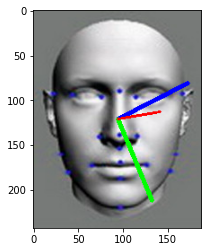

In [42]:
faceModule = mediapipe.solutions.face_mesh

with faceModule.FaceMesh(static_image_mode=True) as faces:
    image = cv2.imread('sad.jpg')
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None: 
      
      for face in results.multi_face_landmarks:
        for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
            shape = image.shape 
            relative_x = int(x * shape[1])
            relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
            #cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    #plt.imshow(image)
            
    plt.imshow(draw_axis(image,0.09115909,-0.49741986,-0.45545673))

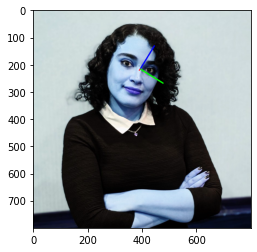

In [43]:
faceModule = mediapipe.solutions.face_mesh

with faceModule.FaceMesh(static_image_mode=True) as faces:
    image = cv2.imread('ren.png')
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    x_coords = []
    y_coords = []
    if results.multi_face_landmarks != None:
        
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x_coords.append(landmark.x)
                y_coords.append(landmark.y)
            
        a = np.array(x_coords)
        b = np.array(y_coords)
        my_mat = np.hstack((a, b))
        roll = roll_predictor.predict(my_mat.reshape(1, -1))
        pitch = pitch_predictor.predict(my_mat.reshape(1, -1))
        yaw = yaw_predictor.predict(my_mat.reshape(1, -1))        
    
    plt.imshow(draw_axis2(image,pitch,yaw,roll))

## Testing With Video Capture

In [49]:

mp_drawing = mediapipe.solutions.drawing_utils
mp_drawing_styles = mediapipe.solutions.drawing_styles
mp_face_mesh = mediapipe.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)
cap = cv2.VideoCapture(0)

with mp_face_mesh.FaceMesh(max_num_faces=1,refine_landmarks=False,min_detection_confidence=0.5,min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        success, image = cap.read()
        image.flags.writeable = False
        x_coords = []
        y_coords = []

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        if results.multi_face_landmarks != None: 
      
          for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x_coords.append(landmark.x)
                y_coords.append(landmark.y)
                  

        a = np.array(x_coords)
        b = np.array(y_coords)
        my_mat = np.hstack((a, b))
        roll = roll_predictor.predict(my_mat.reshape(1, -1))
        pitch = pitch_predictor.predict(my_mat.reshape(1, -1))
        yaw = yaw_predictor.predict(my_mat.reshape(1, -1))
        
        cv2.imshow('Live Video Feed', cv2.flip(draw_axis2(image, yaw, pitch, roll), 1))
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()
    


[ WARN:0@396.946] global /io/opencv/modules/videoio/src/cap_v4l.cpp (889) open VIDEOIO(V4L2:/dev/video0): can't open camera by index


In [48]:
faceModule = mediapipe.solutions.face_mesh
cap = cv2.VideoCapture(0)
mp_drawing = mediapipe.solutions.drawing_utils
mp_drawing_styles = mediapipe.solutions.drawing_styles
mp_face_mesh = mediapipe.solutions.face_mesh
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

with mp_face_mesh.FaceMesh(max_num_faces=1,refine_landmarks=False,min_detection_confidence=0.5,min_tracking_confidence=0.5) as face_mesh:
    while cap.isOpened():
        success, image = cap.read()
        image.flags.writeable = False
    
        #image = cv2.imread('ren.png')
        results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        x_coords = []
        y_coords = []
        if results.multi_face_landmarks != None:

            for face in results.multi_face_landmarks:
                for landmark in face.landmark:
                    x_coords.append(landmark.x)
                    y_coords.append(landmark.y)

            a = np.array(x_coords)
            b = np.array(y_coords)
            my_mat = np.hstack((a, b))
            roll = roll_predictor.predict(my_mat.reshape(1, -1))
            pitch = pitch_predictor.predict(my_mat.reshape(1, -1))
            yaw = yaw_predictor.predict(my_mat.reshape(1, -1))        

        plt.imshow(draw_axis2(image,pitch,yaw,roll))
        cv2.imshow('Live Video Feed', cv2.flip(draw_axis2(image, yaw, pitch, roll), 1))
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable